# Clustering
Mengxia Shi & Mikhail Zakharov | 5 SDBD B1

* 4.1.2 is not done
* All of 5 needs work

Report for November 10th

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import time
import random
import math

from scipy.io import arff
from sklearn import cluster
from sklearn import metrics
from sklearn import neighbors
from scipy.cluster.hierarchy import dendrogram
from hdbscan import hdbscan

## 1. Load data

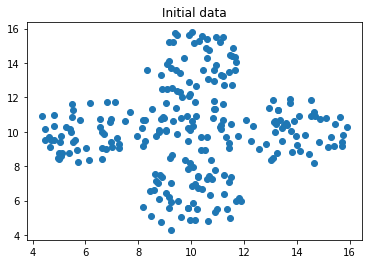

In [4]:
# Selected examples:
# dataset (true number of clusters; ?params)
# k-means (good): DS-577 (3), 2d-4c (4), R15 (15), spherical_5_2 (5)
# k-means (bad): 3-spiral (3), banana (2), curves1 vs. curves2 (2)
# agglo (good): curves2 (2;single), donut1 (2;single), DS-577 (3;complete/ward), ds4c2sc8 (?)
# agglo (bad): flame (2), zelnik2 (3), disk-4500n (2)
# dbscan (good): spiral (3;0.5,5), donut3 (3;0.02,5), dartboard2 (4;0.01,5)
# dbscan (bad): 2d-3c-no123 (3), disk-4600n (2), ds4c2sc8 (8)

def load_dataset(dataset):
    data_load = arff.loadarff(open(data_path + dataset + '.arff', 'r'))[0]
    x = [point[0] for point in data_load]
    y = [point[1] for point in data_load]
    data_xy = list(zip(x,y))
    return x, y, data_xy

dataset = 'spherical_5_2'
true_cluster_number = 5

#data_path = "clustering-benchmark-master/src/main/resources/datasets/artificial/"
data_path = "datasets/artificial/"

x, y, data_xy = load_dataset(dataset)

plt.scatter(x,y)
plt.title("Initial data")
plt.show()

## 2. k-Means

### 2.1.1 Clustering with known true number of clusters

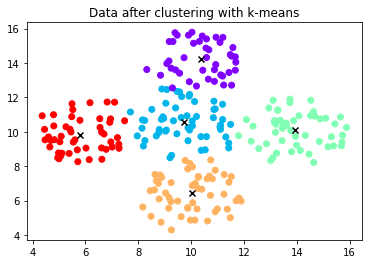

In [8]:
kmeans = cluster.KMeans(n_clusters=true_cluster_number, init='k-means++').fit(data_xy)

center_x = [point[0] for point in kmeans.cluster_centers_]
center_y = [point[1] for point in kmeans.cluster_centers_]

plt.scatter(x, y, c=kmeans.labels_, cmap='rainbow')
plt.scatter(center_x, center_y, marker="x", c="#000")
plt.title("Data after clustering with k-means")
plt.show()

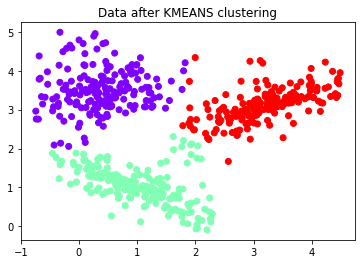

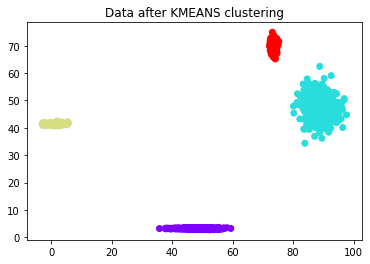

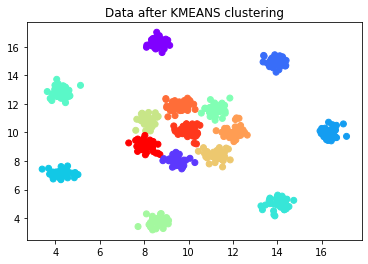

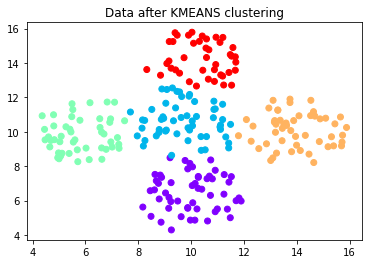

In [7]:
# GOOD
for dataset in [['DS-577', 3], ['2d-4c', 4], ['R15', 15], ['spherical_5_2', 5]]:
    x2, y2, data_xy2 = load_dataset(dataset[0])
    kmeans = cluster.KMeans(n_clusters=dataset[1], init='k-means++').fit(data_xy2)
    plt.scatter(x2, y2, c=kmeans.labels_, cmap='rainbow')
    plt.title("Data after KMEANS clustering")
    plt.show()

### 2.1.2 Automatically determining the true number of clusters using evaluation metrics

Many of the evaluation metrics provided by `sklearn.metrics` require knowledge of the ground truth. They are therefore academic in nature and shall not be considered, as in reality there is no known ground truth.

The metrics considered are therefore the:  
* i) Silhouette Coefficient,
* ii) Calinski-Harabasz Index, and
* iii) Davies-Bouldin Index

### 2.1.2.i Silhouette Coefficient

In [9]:
max_score = -1 # Lower bound for Silhouette coefficient (higher is better)
score = 0      # Initial score
n_clust = 2    # There must be at least two clusters 

results_SC = []
times_SC = []

# or just do 2-30 or something
#while score > (max_score * 0.9):
while n_clust < 10:
    time_start = time.time()
    
    kmeans = cluster.KMeans(n_clusters=n_clust, init='k-means++').fit(data_xy)
    
    time_post_cluster = time.time()
    
    score = metrics.silhouette_score(data_xy, kmeans.labels_)
    
    time_post_score = time.time()
    
    if score > max_score:
        max_score = score
    
    results_SC.append((n_clust, score))
    times_SC.append((time_start, time_post_cluster, time_post_score))
    
    n_clust += 1

best_n_clusters_guess = max(results_SC, key=lambda r: r[1])
print(f"I determine the number of clusters to be: {best_n_clusters_guess[0]}.")
print(f"It took me {times_SC[-1][2]-times_SC[0][0]} seconds to figure that out. ({len(results_SC)} iterations)")

I determine the number of clusters to be: 5.
It took me 0.24600887298583984 seconds to figure that out. (8 iterations)


### 2.1.2.ii Calinski-Harabasz index

In [23]:
max_score = -1 # Assumed lower bound for CH index (higher is better)
score = 0      # Initial score
n_clust = 2    # There must be at least two clusters 

results_CHI = []
times_CHI = []

# or just do 2-30 or something
#while score > (max_score * 0.7):
while n_clust < 10:
    time_start = time.time()
    
    kmeans = cluster.KMeans(n_clusters=n_clust, init='k-means++').fit(data_xy)
    
    time_post_cluster = time.time()
    
    score = metrics.calinski_harabasz_score(data_xy, kmeans.labels_)
    
    time_post_score = time.time()
    
    if score > max_score:
        max_score = score
    
    results_CHI.append((n_clust, score))
    times_CHI.append((time_start, time_post_cluster, time_post_score))
    
    n_clust += 1

best_n_clusters_guess = max(results_CHI, key=lambda r: r[1])
print(f"I determine the number of clusters to be: {best_n_clusters_guess[0]}.")
print(f"It took me {times_CHI[-1][2]-times_CHI[0][0]} seconds to figure that out. ({len(results_CHI)} iterations)")

I determine the number of clusters to be: 5.
It took me 0.262556791305542 seconds to figure that out. (8 iterations)


### 2.1.2.iii Davies–Bouldin index

In [11]:
min_score = 1 # Assumed upper bound for DB index (lower is better)
score = 1.1   # Initial score
n_clust = 2   # There must be at least two clusters 

results_DBI = []
times_DBI = []

# or just do 2-30 or something
while score < (min_score * 1.423):
    time_start = time.time()
    
    kmeans = cluster.KMeans(n_clusters=n_clust, init='k-means++').fit(data_xy)
    
    time_post_cluster = time.time()
    
    score = metrics.davies_bouldin_score(data_xy, kmeans.labels_)
    
    time_post_score = time.time()
    
    if score < min_score:
        min_score = score
    
    results_DBI.append((n_clust, score))
    times_DBI.append((time_start, time_post_cluster, time_post_score))
    
    n_clust += 1

best_n_clusters_guess = min(results_DBI, key=lambda r: r[1])
print(f"I determine the number of clusters to be: {best_n_clusters_guess[0]}.")
print(f"It took me {times_DBI[-1][2]-times_DBI[0][0]} seconds to figure that out. ({len(results_DBI)} iterations)")

I determine the number of clusters to be: 5.
It took me 0.2958190441131592 seconds to figure that out. (9 iterations)


### 2.2 Limits of k-means clustering

(maybe the three metrics above give a good reading for a bad clustering, in which case another metric is needed to judge the clustering's "goodness" ~ test and develop further)

(use curves1 vs. curves2 example to explain the center and convexity limitation of k-means)

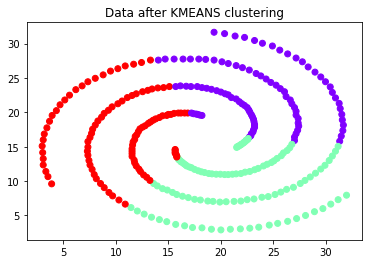

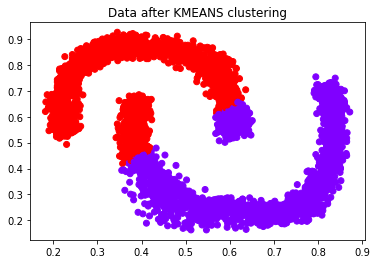

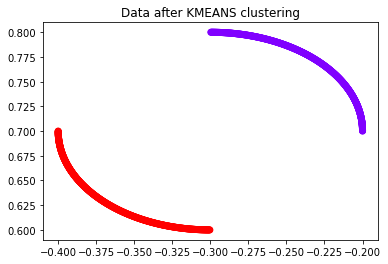

In [8]:
# BAD
for dataset in [['3-spiral', 3], ['banana', 2], ['curves1', 2]]:
    x2, y2, data_xy2 = load_dataset(dataset[0])
    kmeans = cluster.KMeans(n_clusters=dataset[1], init='k-means++').fit(data_xy2)
    plt.scatter(x2, y2, c=kmeans.labels_, cmap='rainbow')
    plt.title("Data after KMEANS clustering")
    plt.show()

## 3. Agglomerative Clustering

### 3.1.1 Clustering with known true number of clusters and with different linkage

In [34]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

agglo.distances_
    
plt.title('Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram
plot_dendrogram(agglo, truncate_mode='level', p=10)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'distances_'

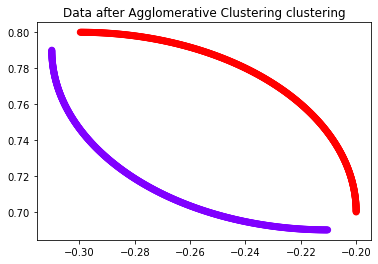

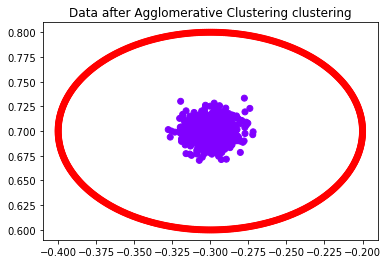

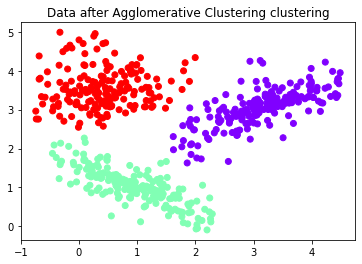

In [9]:
# GOOD
for dataset in [['curves2', 2, 'single'], ['donut1', 2, 'single'], ['DS-577', 3, 'complete']]:
    x2, y2, data_xy2 = load_dataset(dataset[0])
    agglo = cluster.AgglomerativeClustering(n_clusters=dataset[1], linkage=dataset[2]).fit(data_xy2)
    plt.scatter(x2, y2, c=agglo.labels_, cmap='rainbow')
    plt.title("Data after Agglomerative Clustering clustering")
    plt.show()

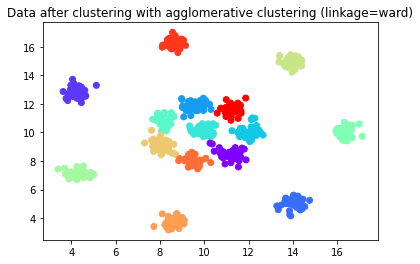

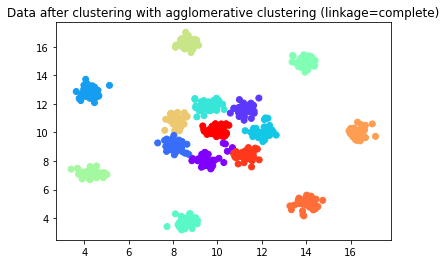

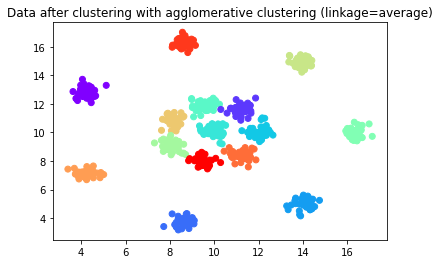

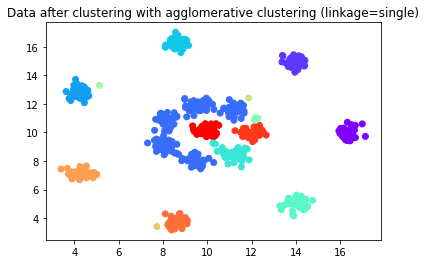

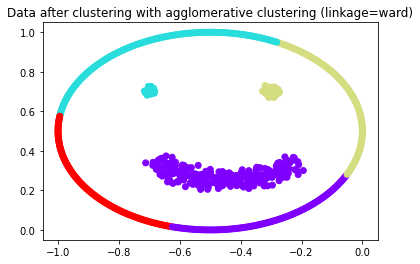

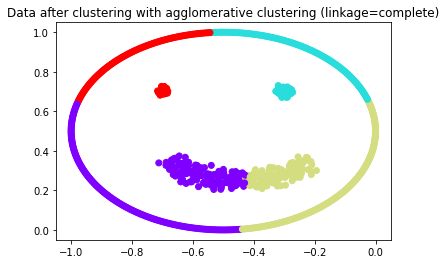

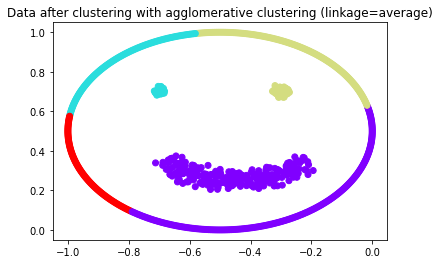

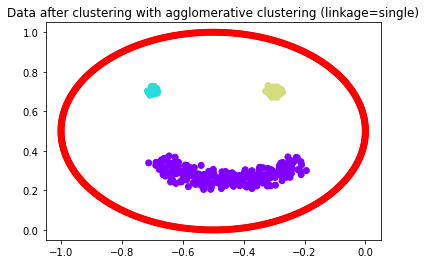

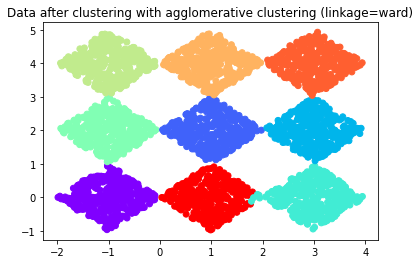

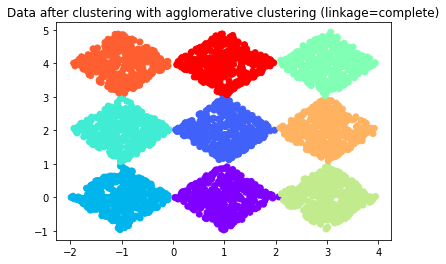

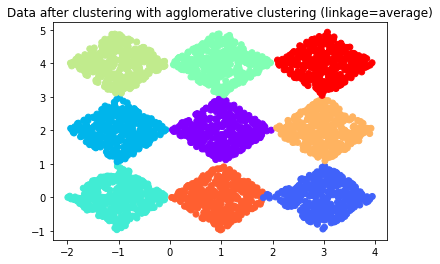

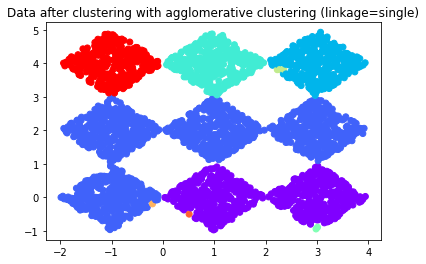

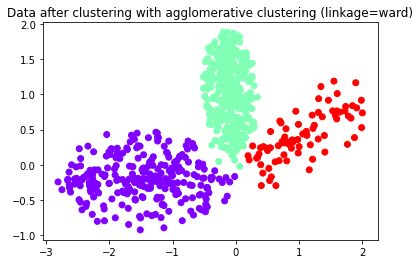

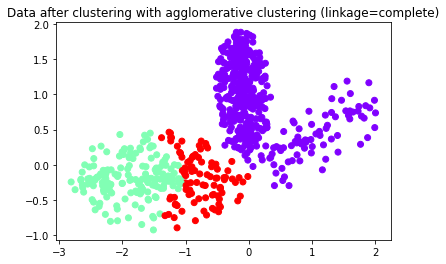

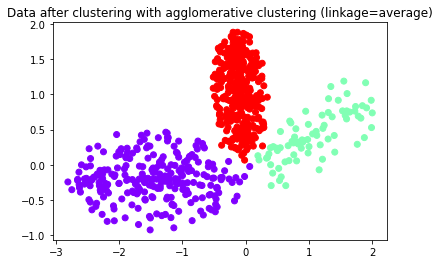

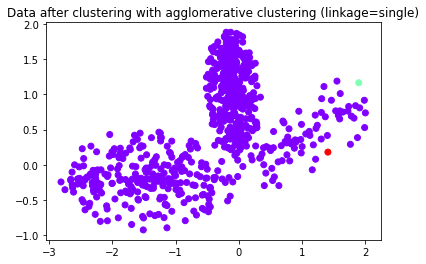

In [104]:
for dataset in [['R15',15], ['smile3',4], ['diamond9',9], ['2d-3c-no123', 3]]:
    x2, y2, data_xy2 = load_dataset(dataset[0])
    for linkage in ['ward', 'complete', 'average', 'single']:
        agglo = cluster.AgglomerativeClustering(n_clusters=dataset[1], linkage=linkage).fit(data_xy2)
        plt.scatter(x2, y2, c=agglo.labels_, cmap='rainbow')
        plt.title("Data after clustering with agglomerative clustering (linkage=" + linkage + ")")
        plt.show()

### 3.1.2 Automatically determining the true number of clusters using evaluation metrics

(~~explain choice of metric if using only one~~)

### 3.1.2.i Silhouette Coefficient

In [39]:
max_score = -1 # Lower bound for Silhouette coefficient (higher is better)
score = 0      # Initial score
n_clust = 2    # There must be at least two clusters 

results_SC = []
times_SC = []

# or just do 2-30 or something
#while score > (max_score * 0.9):
while n_clust < 10:
    time_start = time.time()
    
    agglo = cluster.AgglomerativeClustering(n_clusters=n_clust, linkage='ward').fit(data_xy)
    
    time_post_cluster = time.time()
    
    score = metrics.silhouette_score(data_xy, agglo.labels_)
    
    time_post_score = time.time()
    
    if score > max_score:
        max_score = score
    
    results_SC.append((n_clust, score))
    times_SC.append((time_start, time_post_cluster, time_post_score))
    
    n_clust += 1

best_n_clusters_guess = max(results_SC, key=lambda r: r[1])
print(f"I determine the number of clusters to be: {best_n_clusters_guess[0]}.")
print(f"It took me {times_SC[-1][2]-times_SC[0][0]} seconds to figure that out. ({len(results_SC)} iterations)")

I determine the number of clusters to be: 5.
It took me 0.04886507987976074 seconds to figure that out. (8 iterations)


### 3.1.2.ii Calinski-Harabasz index

In [21]:
max_score = -1 # Assumed lower bound for CH index (higher is better)
score = 0      # Initial score
n_clust = 2    # There must be at least two clusters 

results_CHI = []
times_CHI = []

# or just do 2-30 or something
#while score > (max_score * 0.9):
while n_clust < 10:
    time_start = time.time()
    
    agglo = cluster.AgglomerativeClustering(n_clusters=n_clust, linkage='ward').fit(data_xy)
        
    time_post_cluster = time.time()
    
    score = metrics.calinski_harabasz_score(data_xy, agglo.labels_)
    
    time_post_score = time.time()
    
    if score > max_score:
        max_score = score
    
    results_CHI.append((n_clust, score))
    times_CHI.append((time_start, time_post_cluster, time_post_score))
    
    n_clust += 1

best_n_clusters_guess = max(results_CHI, key=lambda r: r[1])
print(f"I determine the number of clusters to be: {best_n_clusters_guess[0]}.")
print(f"It took me {times_CHI[-1][2]-times_CHI[0][0]} seconds to figure that out. ({len(results_CHI)} iterations)")

I determine the number of clusters to be: 5.
It took me 0.021258115768432617 seconds to figure that out. (8 iterations)


### 3.1.2.iii Davies–Bouldin index

In [26]:
min_score = 1 # Assumed upper bound for DB index (lower is better)
score = 1.1   # Initial score
n_clust = 2   # There must be at least two clusters 

results_DBI = []
times_DBI = []

# or just do 2-30 or something
# while score < (min_score * 1.423):
while n_clust < 10:
    time_start = time.time()
    
    agglo = cluster.AgglomerativeClustering(n_clusters=n_clust, linkage='ward').fit(data_xy)
    
    time_post_cluster = time.time()
    
    score = metrics.davies_bouldin_score(data_xy, agglo.labels_)
    
    time_post_score = time.time()
    
    if score < min_score:
        min_score = score
    
    results_DBI.append((n_clust, score))
    times_DBI.append((time_start, time_post_cluster, time_post_score))
    
    n_clust += 1

best_n_clusters_guess = min(results_DBI, key=lambda r: r[1])
print(f"I determine the number of clusters to be: {best_n_clusters_guess[0]}.")
print(f"It took me {times_DBI[-1][2]-times_DBI[0][0]} seconds to figure that out. ({len(results_DBI)} iterations)")

I determine the number of clusters to be: 6.
It took me 0.03942513465881348 seconds to figure that out. (8 iterations)


### 3.2 Limits of agglomerative clustering

(low-separation, uniform density)

(only based on distance between points, explain with zelnik example)

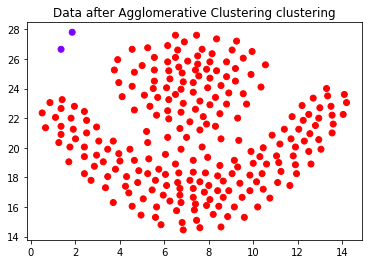

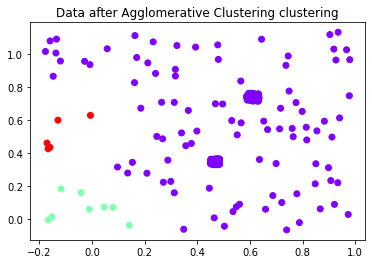

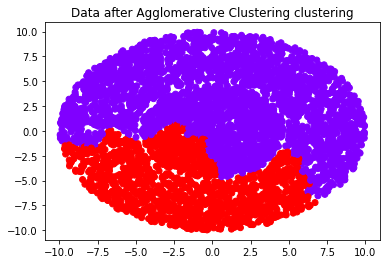

In [10]:
# BAD
for dataset in [['flame', 2, 'single'], ['zelnik2', 3, 'single'], ['disk-4500n', 2, 'complete']]:
    x2, y2, data_xy2 = load_dataset(dataset[0])
    agglo = cluster.AgglomerativeClustering(n_clusters=dataset[1], linkage=dataset[2]).fit(data_xy2)
    plt.scatter(x2, y2, c=agglo.labels_, cmap='rainbow')
    plt.title("Data after Agglomerative Clustering clustering")
    plt.show()

## 4. DBSCAN

### 4.1.1 Clustering with manually set `eps` and `min_samples`

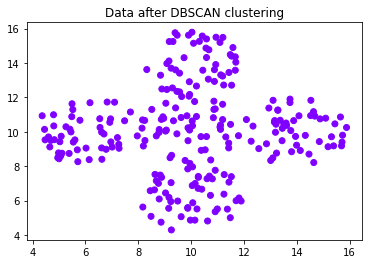

In [105]:
dbscan = cluster.DBSCAN(eps=0.06, min_samples=5).fit(data_xy)

plt.scatter(x, y, c=dbscan.labels_, cmap='rainbow')
plt.title("Data after DBSCAN clustering")
plt.show()

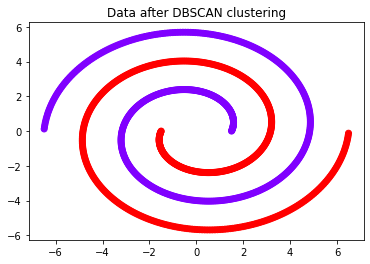

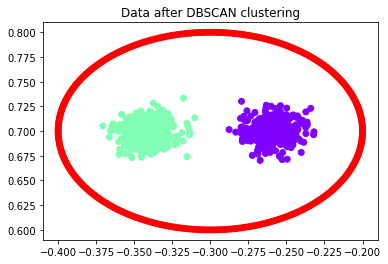

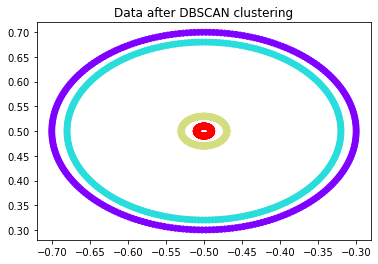

In [112]:
# GOOD
for dataset in [['spiral', 0.5, 3], ['donut3', 0.02, 5], ['dartboard2', 0.01, 5]]:
    x2, y2, data_xy2 = load_dataset(dataset[0])
    dbscan = cluster.DBSCAN(eps=dataset[1], min_samples=dataset[2]).fit(data_xy2)
    plt.scatter(x2, y2, c=dbscan.labels_, cmap='rainbow')
    plt.title("Data after DBSCAN clustering")
    plt.show()

### 4.1.2 Automatically determining the true number of clusters using evaluation metrics

In [122]:
tree = neighbors.KDTree(data_xy)
dist = tree.query(data_xy[:1], k=3)
#print(np.mean(dist))

hmm = [] # average distance to 5 closest points

for (ind, point) in enumerate(data_xy):
    dist, _ = tree.query(data_xy[ind:ind+1], k=5+1) # k=1 compares distance to itself
    hmm.append(np.mean(dist[0][1:]))


plt.hist(hmm, bins=20)
plt.show()

n_points = len(hmm)
points_85 = int(np.floor(n_points * 0.85))
print(points_85)

H,X1 = np.histogram(hmm, bins=n_points)
F1 = np.cumsum(H)

#print(X1[points_85+1])
#for (ind, y) in enumerate(X1):
#     print(ind, y)
print(X1[500])

plt.plot(X1[1:], F1)
plt.show()

AttributeError: 'list' object has no attribute 'size'

In [167]:
# get approximative best eps
def approx_eps(data_xy, k):
    sum_dis = 0
    sample_size = 50
    for i0 in range(sample_size):
        i1 = random.randint(0, len(data_xy) - 1)
        min_dis = []
        for i2 in range(0, len(data_xy)):
            if i1 == i2:
                continue
            dis = math.sqrt((data_xy[i1][0] - data_xy[i2][0]) ** 2 + (data_xy[i1][1] - data_xy[i2][1]) ** 2)
            for i3 in range(k):
                if len(min_dis) < k:
                    min_dis.append(dis)
                    if len(min_dis) == k:
                        min_dis.sort()
                    break
                elif dis < min_dis[i3]:
                    min_dis[i3] = dis
                    break
        sum_dis += min_dis[k - 1]
    return round(sum_dis / sample_size, 4)

# get number of clusters without noise
def filter_noise(clustering, min_cluster_size=50):
    cluster_count = [0] * len(set(clustering))
    for i in clustering:
        if i != -1:
            cluster_count[i] += 1
    size = 0
    for i in range(len(cluster_count)):
        if cluster_count[i] >= min_cluster_size:
            size += 1
    return size

for dataset in ['spiral', 'donut3', 'dartboard2', '2d-3c-no123', 'disk-4600n', 'ds4c2sc8']:
    x2, y2, data_xy2 = load_dataset(dataset)
    min_samples = 2
    best = -1
    best_clustering = []
    best_min_samples = -1
    best_eps = -1
    start = time.time()
    while min_samples <= 15:
        eps = approx_eps(data_xy2, min_samples)
        clustering = cluster.DBSCAN(eps=eps, min_samples=min_samples).fit_predict(data_xy2)
        if len(set(clustering)) == 1:
            min_samples += 1
            continue
        score = metrics.silhouette_score(data_xy2, clustering, metric='euclidean')
        if score > best:
            best = score
            best_clustering = clustering
            best_min_samples = min_samples
            best_eps = eps
        min_samples += 1
    print(f"For dataset '{dataset}':")
    print(f"I determine the number of clusters to be: {filter_noise(best_clustering)}.")
    print(f"It took me {time.time() - start} seconds to figure that out.")

For dataset 'spiral':
I determine the number of clusters to be: 2.
It took me 1.6218271255493164 seconds to figure that out.
For dataset 'donut3':
I determine the number of clusters to be: 3.
It took me 1.5861811637878418 seconds to figure that out.
For dataset 'dartboard2':
I determine the number of clusters to be: 2.
It took me 1.524543046951294 seconds to figure that out.
For dataset '2d-3c-no123':
I determine the number of clusters to be: 2.
It took me 1.0551598072052002 seconds to figure that out.
For dataset 'disk-4600n':
I determine the number of clusters to be: 8.
It took me 9.386029958724976 seconds to figure that out.
For dataset 'ds4c2sc8':
I determine the number of clusters to be: 1.
It took me 0.8205459117889404 seconds to figure that out.


### 4.2 Limits of DBSCAN clustering

struggles with uniform density

and can get tripped up on "intermediary chains" (see cure-* examples)

but does well against noise (duh)

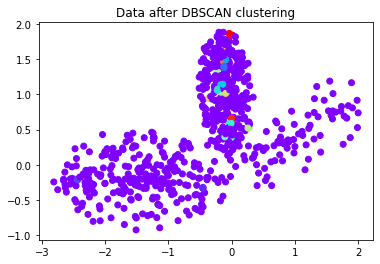

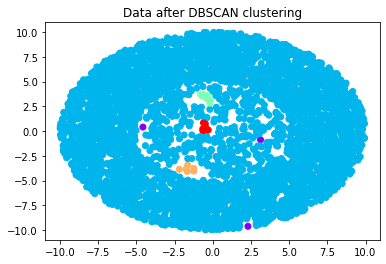

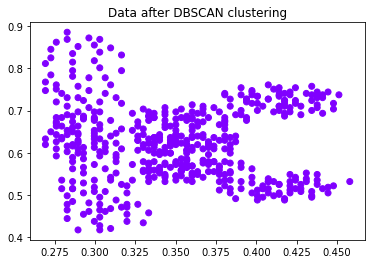

In [121]:
# BAD
for dataset in [['2d-3c-no123', 0.02, 3], ['disk-4600n', 0.5, 3], ['ds4c2sc8', 0.02, 2]]:
    x2, y2, data_xy2 = load_dataset(dataset[0])
    dbscan = cluster.DBSCAN(eps=dataset[1], min_samples=dataset[2]).fit(data_xy2)
    plt.scatter(x2, y2, c=dbscan.labels_, cmap='rainbow')
    plt.title("Data after DBSCAN clustering")
    plt.show()

## 5. HDBSCAN

"insensitive to density variation"

compare DBSCAN and HDBSCAN -- pros cons of each, performance (time) difference?

### 5.1.1 Clustering with manually set `min_samples`

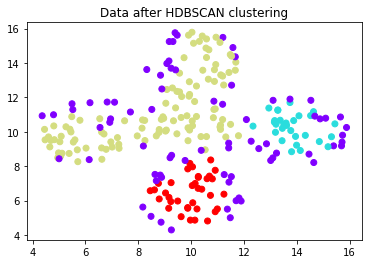

In [9]:
maa = hdbscan.HDBSCAN(min_cluster_size=10).fit(data_xy)

plt.scatter(x, y, c=maa.labels_, cmap='rainbow')
plt.title("Data after HDBSCAN clustering")
plt.show()

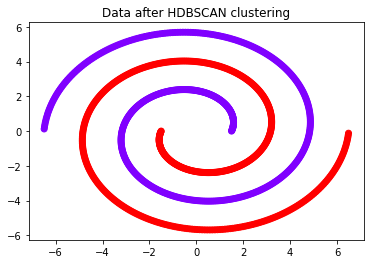

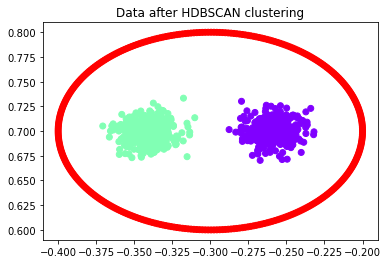

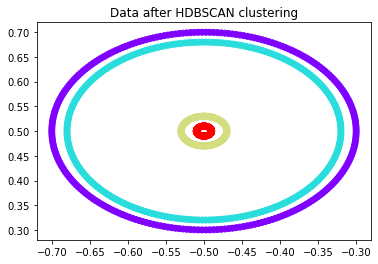

In [193]:
# GOOD
for dataset in [['spiral', 5], ['donut3', 5], ['dartboard2', 3]]:
    x2, y2, data_xy2 = load_dataset(dataset[0])
    clustering = hdbscan(data_xy2, min_samples=dataset[1], min_cluster_size=50)
    plt.scatter(x2, y2, c=clustering[0], cmap='rainbow')
    plt.title("Data after HDBSCAN clustering")
    plt.show()

### 5.1.2 Automatically determining the true number of clusters using evaluation metrics

In [206]:
for dataset in ['spiral', 'donut3', 'dartboard2', '2d-3c-no123', 'disk-4600n', 'ds4c2sc8']:
    x2, y2, data_xy2 = load_dataset(dataset)
    min_samples = 2
    best = -1
    best_clustering = []
    best_min_samples = -1
    start = time.time()
    while min_samples <= 15:
        clustering = hdbscan(data_xy2, min_samples=min_samples, min_cluster_size=50)[0]
        if len(set(clustering)) == 1:
            min_samples += 1
            continue
        score = metrics.silhouette_score(data_xy2, clustering, metric='euclidean')
        if score > best:
            best = score
            best_clustering = clustering
            best_min_samples = min_samples
        min_samples += 1
    print(f"For dataset '{dataset}':")
    print(f"I determine the number of clusters to be: {len(set(best_clustering))}.")
    print(f"It took me {time.time() - start} seconds to figure that out.")

For dataset 'spiral':
I determine the number of clusters to be: 2.
It took me 0.4677271842956543 seconds to figure that out.
For dataset 'donut3':
I determine the number of clusters to be: 3.
It took me 0.41950011253356934 seconds to figure that out.
For dataset 'dartboard2':
I determine the number of clusters to be: 4.
It took me 0.4268929958343506 seconds to figure that out.
For dataset '2d-3c-no123':
I determine the number of clusters to be: 3.
It took me 0.26186490058898926 seconds to figure that out.
For dataset 'disk-4600n':
I determine the number of clusters to be: 14.
It took me 4.995229244232178 seconds to figure that out.
For dataset 'ds4c2sc8':
I determine the number of clusters to be: 4.
It took me 0.13772916793823242 seconds to figure that out.


### 5.2 Limits of HDBSCAN clustering

struggles with uniform density

and can get tripped up on "intermediary chains" (see cure-* examples)

but does well against noise (duh)

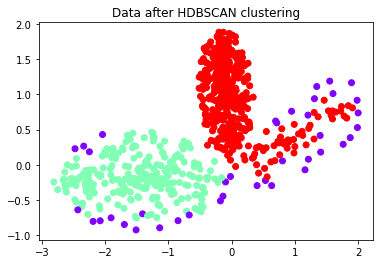

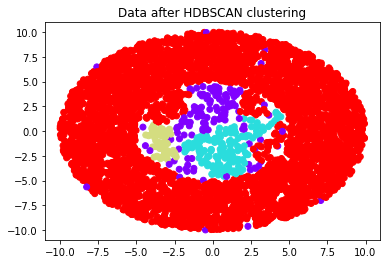

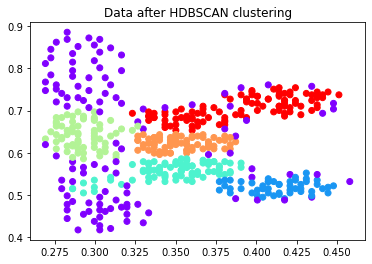

In [203]:
# BAD
for dataset in [['2d-3c-no123', 7], ['disk-4600n', 2], ['ds4c2sc8', 3]]:
    x2, y2, data_xy2 = load_dataset(dataset[0])
    clustering = hdbscan(data_xy2, min_samples=dataset[1], min_cluster_size=50)
    plt.scatter(x2, y2, c=clustering[0], cmap='rainbow')
    plt.title("Data after HDBSCAN clustering")
    plt.show()

## Notes

Measure time:
* to compare between different clustering methods
* to see how execution time depends on number of clusters to calculate
* between different stop conditions\*

\* All these things are choices to justify. What stop condition to use (time vs. accuracy trade-off)? ...

evaluate method within itself (diff params) and with other methods using the best config on same data

do all three metrics, because you can then decide on a consensus between the three

maybe try something with dendrograms?

maybe don't be dumb and use _convex_ datasets for DBSCAN so you can also evaluate using the same metrics

## Links
* https://pymfe.readthedocs.io/en/latest/auto_examples/03_miscellaneous_examples/plot_using_pandas_csv_arff.html

* https://github.com/deric/clustering-benchmark